In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [12]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

os.system('mkdir stack_overflow_16k; mv train stack_overflow_16k; mv test stack_overflow_16k')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

In [13]:
os.listdir(dataset_dir)

['test', 'train']

In [14]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [15]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [18]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("text", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

text b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n'
Label 1
text b'"static class, static constructors and static properties i have a static class that has only static properties and a static constructor. when i try to access or set the value of property (with a backing field) the static constructor is not called. however, if i define a static method and try to call it the constructor is executed...i believe properties are just syntactical suga

In [21]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [19]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to csharp
Label 1 corresponds to java


In [22]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [23]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [24]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [25]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [26]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [27]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [28]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label javascript
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  38,  450,   65,    7,   16,   12,  892,  265,  186,  451,   44,
          11,    6,  685,    3,   46,    4, 2062,    2,  485,    1,    6,
         158,    7,  479,    1,   26,   20,  158,    7,  479,    1,  502,
          38,  450,    1, 1767, 1763,    1,    1,    1,    1,    1,    1,
           1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [29]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [30]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
embedding_dim = 16

In [42]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
             metrics=['accuracy']
             )

In [48]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5084 - accuracy: 0.8606 - val_loss: 0.5747 - val_accuracy: 0.8094
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4888 - accuracy: 0.8662 - val_loss: 0.5634 - val_accuracy: 0.8125
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4716 - accuracy: 0.8700 - val_loss: 0.5529 - val_accuracy: 0.8175
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4562 - accuracy: 0.8783 - val_loss: 0.5436 - val_accuracy: 0.8169
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4394 - accuracy: 0.8736 - val_loss: 0.5351 - val_accuracy: 0.8181
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4252 - accuracy: 0.8805 - val_loss: 0.5272 - val_accuracy: 0.8194
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4117 - accuracy: 0.8874 - val_loss: 0.5200 - val_accuracy: 0.8225
Epoch 

In [49]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 4s 14ms/step - loss: 0.5538 - accuracy: 0.7997
Loss:  0.5538250803947449
Accuracy:  0.7997499704360962


In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

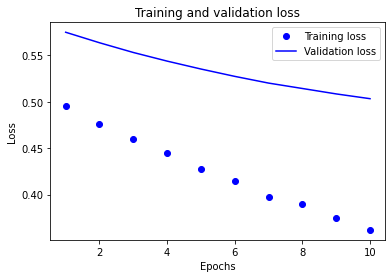

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

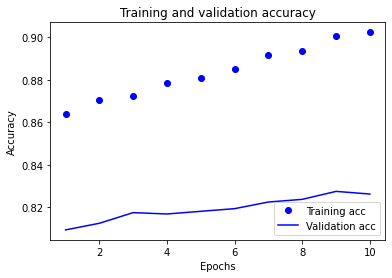

In [53]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [54]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.5611 - accuracy: 0.7982
0.7997499704360962


In [57]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [58]:
examples = [
  "from pandas import pd"
]

export_model.predict(examples)

array([[0.42234528, 0.48237792, 0.43619296, 0.6958798 ]], dtype=float32)